In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import statsmodels.api as sm
import numpy as np
import geopandas as gpd
from matplotlib import pyplot as plt
from haversine import haversine_vector, Unit
pd.options.mode.chained_assignment = None  # default='warn'
from sttn.data.lehd import OriginDestinationEmploymentDataProvider
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
provider = OriginDestinationEmploymentDataProvider()
from sklearn.model_selection import StratifiedKFold
import scipy.optimize as optimize

import math
from sttn.network import SpatioTemporalNetwork
from sttn.utils import add_distance
import os
%matplotlib inline

In [2]:
cities = [
    ('New York City', 'ny', ['New York County, NY', 'Queens County, NY','Kings County, NY','Bronx County, NY','Richmond County, NY']),
    ('Los Angeles', 'ca', ['Los Angeles County, CA']),
    ('Chicago', 'il', ['Cook County, IL']),
    ('Houston', 'tx', ['Harris County, TX']),
    ('Boston', 'ma', ['Suffolk County, MA', 'Middlesex County, MA']),
    ('Phoenix', 'az', ['Maricopa County, AZ']),
    ('Philadelphia', 'pa', ['Philadelphia County, PA']),
    ('San Antonio', 'tx', ['Bexar County, TX']),
    ('San Diego', 'ca', ['San Diego County, CA']),
    ('Dallas', 'tx', ['Dallas County, TX']),
    ('San Jose', 'ca', ['Santa Clara County, CA']),
    ('Austin', 'tx', ['Travis County, TX']),
]

In [3]:
def build_training_set(network, target_column):
    # explode the dataset to include all node pairs
    node_ids = network.nodes.index.values
    origins = pd.DataFrame(node_ids, columns = ['origin'])
    destinations = pd.DataFrame(node_ids, columns = ['destination'])
    cartesian_product = origins.merge(destinations, how='cross')
    
    # compute distnace between all pairs
    centroid = network.nodes.centroid
    centroid_long = centroid.x
    centroid_long.name = 'long'
    centroid_lat = centroid.y
    centroid_lat.name = 'lat'
    centroids = pd.concat([centroid_long, centroid_lat], axis=1)
    centroid_from = cartesian_product.join(centroids, on=network._origin).rename(columns={'long': 'long_from', 'lat': 'lat_from'})
    centroid_all = centroid_from.join(centroids, on=network._destination).rename(columns={'long': 'long_to', 'lat': 'lat_to'})
    from_points = list(zip(centroid_all.lat_from, centroid_all.long_from))
    to_points = list(zip(centroid_all.lat_to, centroid_all.long_to))
    centroid_all['distance'] = haversine_vector(from_points, to_points, Unit.KILOMETERS)
    centroid_all.drop(['long_from', 'lat_from', 'long_to', 'lat_to'], axis=1, inplace=True)
    centroid_all.loc[centroid_all.distance == 0, 'distance'] = 0.2
    
    # compute jobs and residence
    comp_aggs={target_column: 'sum'}
    jobs = city_network.agg_adjacent_edges(aggs=comp_aggs, outgoing=False).rename(columns={target_column: 'jobs'})
    residence = city_network.agg_adjacent_edges(aggs=comp_aggs, outgoing=True).rename(columns={target_column: 'residence'})
    features = centroid_all.join(residence, on='origin').join(jobs, on='destination')
    
    # merge flow data
    flow = network.edges.rename(columns={target_column: 'flow'})[['origin', 'destination', 'flow']]
    combined = features.merge(flow, how='left', on=['origin', 'destination']).fillna(0)
    
    return combined

In [5]:
target_columns = ['S000']
for city, state, conties in cities:
    print(city)
    state_network = provider.get_data(state=state, year=2018)
    city_network = state_network.filter_nodes(state_network.nodes.county.isin(conties))
    for target_column in target_columns:
        training_set = build_training_set(city_network, target_column)
    training_set.to_csv('cities/%s.csv'%city,index=False)

New York City


### doubly constrained, fit u,v together in iterations

In [4]:
def getbins(df, nbins=20):     
    df['bin'] = pd.qcut(df['distance'], q=20)
    df.sort_values(by='bin', inplace=True)
    df.rename(columns={'jobs':'S000jobs', 'residence':'S000residence','flow':'S000flow'}, inplace=True)
    
    return df
def balancing(test,target,iterationNum,iteration = 20):
#     print(target,'iteration', iterationNum)
    if target+'B' not in test.columns:
        test[target+'B'] = 1
    test[target+'BDF'] = test[target+'jobs']*test[target+'f(d)']*test[target+'B']
    if target+'A' in test.columns:
        del test[target+'A']
    del test[target+'B']
    test = test.groupby(['origin']).agg({target+'BDF':sum}).\
    rename(columns={target+'BDF':target+'A'}).reset_index().\
    merge(test,on=['origin'],how='right')
    test[target+'A'] = 1/test[target+'A']
    test[target+'AOF'] = test[target+'residence']*test[target+'f(d)']*test[target+'A']
    test = test.groupby(['destination']).agg({target+'AOF':sum}).\
    rename(columns={target+'AOF':target+'B'}).reset_index().\
    merge(test,on=['destination'],how='right')
    test[target+'B'] = 1/test[target+'B']
    test[target+'pred'] = test[target+'residence']*test[target+'jobs']*test[target+'f(d)']*\
                        test[target+'A']*test[target+'B']
    
    resultO = test[['origin',target+'residence']].drop_duplicates().\
    merge(test.groupby(['origin'])[[target+'pred']].sum().reset_index(),on=['origin'],how='left')
    resultO['percentage'] = np.abs(resultO[target+'residence'] - resultO[target+'pred'])/resultO[target+'residence']
    resultO = resultO['percentage'].mean()

    resultD = test[['destination',target+'jobs']].drop_duplicates().\
    merge(test.groupby(['destination'])[[target+'pred']].sum().reset_index(),on=['destination'],how='left')
    resultD['percentage'] = np.abs(resultD[target+'jobs'] - resultD[target+'pred'])/resultD[target+'jobs']
    resultD = resultD['percentage'].mean()
#     print(resultO,resultD)
    if resultO < 0.02 and resultD < 0.02:
        return test
    else:
        if iterationNum < iteration:
            return balancing(test,target,iterationNum = iterationNum+1,iteration = 20)
        else:
            return test
        
def doubly_constrained_model_AB(data,target):
    

    binoutput = pd.DataFrame()
    # estimate F for each bin
    for b in data['bin'].unique():
        subData = data[data['bin'] == b]
        X = subData[target+'residence'] * subData[target+'jobs']

        y = subData[target+'flow']

        model = sm.OLS(y,X).fit()

        subData[target+'f(d)'] = model.params[0]       
        binoutput = pd.concat([binoutput,subData])
    binoutput = balancing(binoutput,target,iterationNum=1,iteration = 20)
    binoutput = binoutput[['origin','destination',target+'flow',target+'pred',target+'f(d)','bin']]

#         binoutput = binoutput[['origin','destination',target+'flow',target+'A',target+'B',target+'f(d)','bin',target+'flowPred']]
       

    return binoutput

In [71]:
!mkdir constrainCTdistbinsAB
fdf = []
outputDir = 'constrainCTdistbinsAB/'
cities = os.listdir('cities/')
separate_income = False
target = 'S000'
for city in cities:
    if '.csv' in city:
        df = pd.read_csv('cities/'+city)
        dataUV = doubly_constrained_model_AB(getbins(df),target)
        dataUV[['origin','destination',target+'flow',target+'pred']].to_csv(outputDir+city,index=False)
        grouped_bfpl = dataUV.groupby('bin').agg({target+'f(d)': 'min'})
        grouped_bfpl = grouped_bfpl.reset_index()
        fdf += [grouped_bfpl]

mkdir: cannot create directory ‘constrainCTdistbinsAB’: File exists


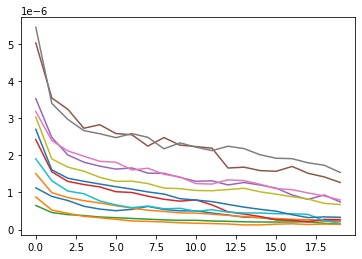

In [73]:
for grouped_bfpl in fdf:
    plt.plot(grouped_bfpl[target+'f(d)'])
#     break

# baseline

### unconstrain model, power law

In [29]:

def power_law(x,k,a):
    return k*((x[:,0]**a)*x[:,1]*x[:,2])
def baseline_fit(df,target):
    X = ['distance',target+'jobs',target+'residence']
    y = target+'flow'
    pars, cov = optimize.curve_fit(f=power_law, xdata=df[X].values, ydata=df[y].values, bounds=(-np.inf, np.inf))
    return pars
def baseline_predict(test,target,pars):
    test[target+'k'] = pars[0]
    test[target+'a'] = pars[1]
    test[target+'pred'] = test[target+'k']*(test['distance']**test[target+'a'])*test[target+'jobs']*test[target+'residence']
    return test
def crossvalidation(df,target):
    mseList = []
    for i in range(5):
        train, test = train_test_split(df)
        pars = baseline(train)
        test = baseline_fit(test)
        mseList += [mean_squared_error(test[target+'flow'],test[target+'pred'])]
    return np.mean(mseList)

In [8]:

cities = os.listdir('cities/')
citiesDir = 'cities/'
mseDir = {}

for city in cities:
    if '.csv' in city:
        df = pd.read_csv(citiesDir+city)
        df.rename(columns={'jobs':'S000jobs', 'residence':'S000residence','flow':'S000flow'}, inplace=True)
        mseDir[city] = crossvalidation(df,target='S000')
        print(city)

Chicago.csv
Phoenix.csv
New York City.csv
San Diego.csv
San Jose.csv
Austin.csv
San Antonio.csv
Philadelphia.csv
Dallas.csv


KeyboardInterrupt: 

In [534]:
mseDir

{'Chicago.csv': 15.451858943585574,
 'Phoenix.csv': 14.697585796076316,
 'New York City.csv': 4.684721967212441,
 'San Diego.csv': 46.13230610909322,
 'San Jose.csv': 57.889232965274154,
 'Austin.csv': 147.26938613781525,
 'San Antonio.csv': 39.703481618282105,
 'Philadelphia.csv': 22.060472064208714,
 'Dallas.csv': 27.40118340943202,
 'Houston.csv': 41.08473006522449,
 'Boston.csv': 49.39656983431756,
 'Los Angeles.csv': 5.779911660211235}

In [ ]:
def power_law(x,k,a):
    return k*((x[:,0]**a)*x[:,1]*x[:,2])
def unconstrained_powerlaw(data,target):

    X = data[['distance',target+'jobs',target+'residence']].values
    y = data[target+'flow'].values
    pars, cov = optimize.curve_fit(f=power_law, xdata=X, ydata=y, bounds=(-np.inf, np.inf))
#         print(pars)
    data[target+'k'] = pars[0]
    data[target+'a'] = pars[1]
    data[target+'pred'] = data[target+'k']*(data['distance']**data[target+'a'])*data[target+'jobs']*data[target+'residence']
    #data = data[['origin', 'destination', target+'flow', target+'pred']]
    return data

In [ ]:
!mkdir unconstrainCTPowerlaw/
cities = os.listdir('cities/')
citiesDir = 'cities/'

outputDir = 'unconstrainCTPowerlaw/'

for city in cities:
    if '.csv' in city:
        df = pd.read_csv(citiesDir+city)
        df.rename(columns={'jobs':'S000jobs', 'residence':'S000residence','flow':'S000flow'}, inplace=True)
        dataUV = unconstrained_powerlaw(df,target='S000')
        dataUV.to_csv(outputDir+city,index=False)


# bucked unconstrained power law with distance

In [24]:
def power_law(x,k,a):
    return k*((x[:,0]**a)*x[:,1]*x[:,2])

def fit_unconstrained_powerlaw(data,target):
    X = data[['distance', target+'jobs', target+'residence']].values
    y = data[target+'flow'].values
    pars, cov = optimize.curve_fit(f=power_law, xdata=X, ydata=y, bounds=(-np.inf, np.inf))
    return pars

def predict_unconstrained_powerlaw(data,target,model):
    k = model[0]
    a =  model[1]
    data[target+'pred'] = (data['distance']**a)*data[target+'jobs']*data[target+'residence']*k
    return data

def fit_piece_power_law(data,target, bins = 17):
    bins_list = data['bin'].unique()    
    bin_to_model = {}
    for b in bins_list:
        subData = data[data['bin'] == b]
        model = fit_unconstrained_powerlaw(subData,target)
        bin_to_model[b] = model
        
    return bin_to_model
    
def predict_piece_power_law(data,target, model):
    bins_list = data['bin'].unique()
    predictions_all = pd.DataFrame()
    for b in bins_list:
        bin_model = model[b]
        subData = data[data['bin'] == b]
        predicted = predict_unconstrained_powerlaw(subData, target,bin_model)
        predictions_all = pd.concat([predictions_all, predicted])
        
    return predictions_all

In [ ]:
def crossvalidation(df,target,bins):
    df['bin'] = pd.qcut(df['distance'], q=bins)
    df['bin'] = df['bin'].astype(str)
    df.sort_values(by='bin', inplace=True)
    df.rename(columns={'jobs':'S000jobs', 'residence':'S000residence','flow':'S000flow'}, inplace=True)
    mseList = []
    skf = StratifiedKFold(n_splits=5)
    X = df[['origin', 'destination', 'distance', target+'residence',
       target+'jobs', target+'flow']].values
    y = df[['bin']].values
    skf.get_n_splits(X,y)
    for train_index, test_index in skf.split(X, y):
        train, test = df.loc[train_index], df.loc[test_index]
        bin_to_model = fit_bucketed_power_law(train,target)
        test = predict_bucketed_power_law(test,target,bin_to_model)
        mseList += [mean_squared_error(test[target+'flow'],test[target+'pred'])]
    return np.mean(mseList)

In [99]:

cities = os.listdir('cities/')
citiesDir = 'cities/'
mseDir = {}

for city in cities:
    if '.csv' in city:
        df = pd.read_csv(citiesDir+city)
        df.rename(columns={'jobs':'S000jobs', 'residence':'S000residence','flow':'S000flow'}, inplace=True)
        mseDir[city] = crossvalidation(df,target='S000',bins=17)
        print(city)

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 600.

# find the min bucket to make sure bucked gravity model has the same performance as gravity model with distance


!mkdir unconstrainCTBuckedPowerlaw/
cities = os.listdir('cities/')
citiesDir = 'cities/'
refDir = 'unconstrainCTPowerlaw/'
outputDir = 'unconstrainCTBuckedPowerlaw/'
fdf = []
binDict = {}
for city in cities:
    if '.csv' in city:
        print(city)
        df = pd.read_csv(citiesDir+city)
        refdf = pd.read_csv(refDir+city)
        refmse = mean_squared_error(refdf['S000flow'],refdf['S000pred'])
    
        df.rename(columns={'jobs':'S000jobs', 'residence':'S000residence','flow':'S000flow'}, inplace=True)
        for i in np.arange(10,10000,5):
            predicted_bfpl = unconstrained_bucked_powerlaw(df, 'S000',bins=i)
            mse = mean_squared_error(predicted_bfpl['S000flow'],predicted_bfpl['S000pred'])
            if mse <= refmse:
                print(i)
                predicted_bfpl[['origin', 'destination','S000flow','S000pred']].to_csv(outputDir+city,index=False)

                grouped_bfpl = predicted_bfpl.groupby('bin').agg({'S000f': 'min'})
                grouped_bfpl = grouped_bfpl.reset_index()
                fdf += [grouped_bfpl]
                binDict[city] = i
                break


In [23]:
binDict = {'Chicago.csv': 15,
 'San Diego.csv': 30,
 'San Jose.csv': 40,
 'Austin.csv': 65,
 'San Antonio.csv': 90,
 'Philadelphia.csv': 35,
 'Dallas.csv': 25,
 'Houston.csv': 45,
 'Boston.csv': 180,
 'Phoenix.csv': 310,
 'New York City.csv': 630,
 'Los Angeles.csv': 980}
binDict

{'Chicago.csv': 15,
 'San Diego.csv': 30,
 'San Jose.csv': 40,
 'Austin.csv': 65,
 'San Antonio.csv': 90,
 'Philadelphia.csv': 35,
 'Dallas.csv': 25,
 'Houston.csv': 45,
 'Boston.csv': 180,
 'Phoenix.csv': 310,
 'New York City.csv': 630,
 'Los Angeles.csv': 980}

In [53]:
def power_law(x,k,a):
    return k*((x[:,0]**a)*x[:,1]*x[:,2])
def bucked_power_law(x,f):
    return f*(x[:,0]*x[:,1]*x[:,2])
def unconstrained_bucked_powerlaw_fit(data, target):
    binf = {}
    X = data[['distance',target+'jobs',target+'residence']].values
    y = data[target+'flow'].values
    pars, cov = optimize.curve_fit(f=power_law, xdata=X, ydata=y, bounds=(-np.inf, np.inf))
#         print(pars)
    data[target+'k'] = pars[0]

    # estimate F for each bin
    for b in data['bin'].unique():
        subData = data[data['bin'] == b]
        X = subData[target+'jobs'].values*subData[target+'residence'].values*subData[target+'k'].values
        y = subData[target+'flow'].values
        model = sm.OLS(y,X)
        results = model.fit()
        subData[target+'f'] = results.params[0]
        binf[b] = results.params[0]
    return (pars[0],binf)
def unconstrained_bucked_powerlaw_predict(test,target,k,binf):
    test[target+'k'] = k
    test[target+'f'] = test['bin'].apply(lambda x:binf[x]).astype(float)
    test[target+'pred'] = test[target+'k']*test[target+'f']*test[target+'jobs']*test[target+'residence']
    return test

In [13]:
def crossvalidation(df,target,bins):
    df['bin'] = pd.qcut(df['distance'], q=bins)
    df['bin'] = df['bin'].astype(str)
    df.sort_values(by='bin', inplace=True)
    df.rename(columns={'jobs':'S000jobs', 'residence':'S000residence','flow':'S000flow'}, inplace=True)
    mseList = []
    skf = StratifiedKFold(n_splits=5)
    X = df[['origin', 'destination', 'distance', 'S000residence',
       'S000jobs', 'S000flow']].values
    y = df[['bin']].values
    skf.get_n_splits(X,y)
    for train_index, test_index in skf.split(X, y):
        train, test = df.loc[train_index], df.loc[test_index]
        k, binf = unconstrained_bucked_powerlaw(train, target,bins)
#         print(len(binf),bins)
        test = unconstrained_bucked_powerlaw_fit(test,target,k,binf)
        mseList += [mean_squared_error(test[target+'flow'],test[target+'pred'])]
    return np.mean(mseList)

In [63]:

cities = os.listdir('cities/')
citiesDir = 'cities/'
mseDir = {}

for city in cities:
    if '.csv' in city:
        df = pd.read_csv(citiesDir+city)
        df.rename(columns={'jobs':'S000jobs', 'residence':'S000residence','flow':'S000flow'}, inplace=True)
        mseDir[city] = crossvalidation(df,target='S000',bins=binDict[city])
        print(city)

Chicago.csv
Phoenix.csv
New York City.csv
San Diego.csv
San Jose.csv
Austin.csv
San Antonio.csv
Philadelphia.csv
Dallas.csv
Houston.csv
Boston.csv
Los Angeles.csv


In [67]:
baselineMSE = {'Chicago.csv': 15.451858943585574,
 'Phoenix.csv': 14.697585796076316,
 'New York City.csv': 4.684721967212441,
 'San Diego.csv': 46.13230610909322,
 'San Jose.csv': 57.889232965274154,
 'Austin.csv': 147.26938613781525,
 'San Antonio.csv': 39.703481618282105,
 'Philadelphia.csv': 22.060472064208714,
 'Dallas.csv': 27.40118340943202,
 'Houston.csv': 41.08473006522449,
 'Boston.csv': 49.39656983431756,
 'Los Angeles.csv': 5.779911660211235}

In [69]:
pd.DataFrame({'city':mseDir.keys(),'baseline':baselineMSE.values(),'bins':mseDir.values()})

,city,baseline,bins
0,Chicago.csv,15.451859,15.789311
1,Phoenix.csv,14.697586,15.895549
2,New York City.csv,4.684722,4.545241
3,San Diego.csv,46.132306,45.574976
4,San Jose.csv,57.889233,55.243015
5,Austin.csv,147.269386,115.867285
6,San Antonio.csv,39.703482,42.728907
7,Philadelphia.csv,22.060472,20.708266
8,Dallas.csv,27.401183,27.439487
9,Houston.csv,41.084730,37.981710


In [152]:

!mkdir unconstrainCTBuckedPowerlaw/
cities = os.listdir('cities/')
citiesDir = 'cities/'
refDir = 'unconstrainCTPowerlaw/'
outputDir = 'unconstrainCTBuckedPowerlaw/'
fdf = []
for city in cities:
    if '.csv' in city:
        print(city)
        df = pd.read_csv(citiesDir+city)
        df.rename(columns={'jobs':'S000jobs', 'residence':'S000residence','flow':'S000flow'}, inplace=True)

        predicted_bfpl = unconstrained_bucked_powerlaw(df, 'S000',bins=binDict[city])
        mse = mean_squared_error(predicted_bfpl['S000flow'],predicted_bfpl['S000pred'])
        predicted_bfpl[['origin', 'destination','S000flow','S000pred']].to_csv(outputDir+city,index=False)
        grouped_bfpl = predicted_bfpl.groupby('bin').agg({'S000f': 'min'})
        grouped_bfpl = grouped_bfpl.reset_index()
        fdf += [grouped_bfpl]
            


mkdir: cannot create directory ‘unconstrainCTBuckedPowerlaw/’: File exists
Chicago.csv
Phoenix.csv
New York City.csv
San Diego.csv
San Jose.csv
Austin.csv
San Antonio.csv
Philadelphia.csv
Dallas.csv
Houston.csv
Boston.csv
Los Angeles.csv


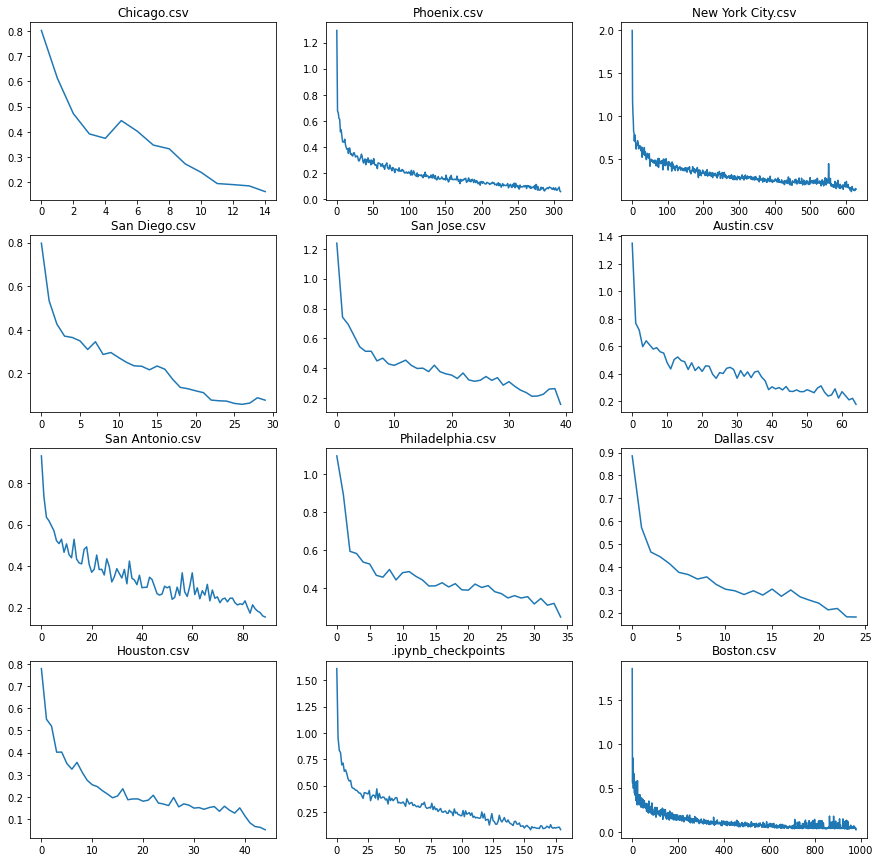

In [154]:
fig, ax = plt.subplots(4,3,figsize=(15,15))
for i,grouped_bfpl in enumerate(fdf):
#     print(i)
#     ax[1,2].plot(grouped_bfpl['S000f'])
    ax[i//3,i%3].plot(grouped_bfpl['S000f'])
    ax[i//3,i%3].set_title(cities[i])

In [162]:

for city in cities:
    if '.csv' in city:
        df = pd.read_csv(citiesDir+city)
        binDict[city] = [binDict[city],len(df['origin'].unique())]

Text(0, 0.5, 'census tract')

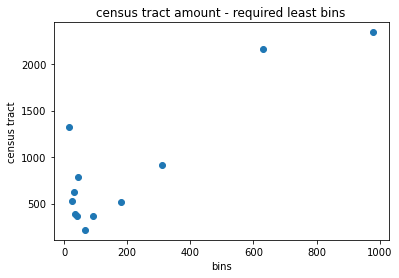

In [186]:
plt.plot(np.array(list(binDict.values()))[:,0],np.array(list(binDict.values()))[:,1],'o')
plt.title('census tract amount - required least bins')
plt.xlabel('bins')
plt.ylabel('census tract')

In [191]:

!mkdir unconstrainCTBuckedPowerlaw/
cities = os.listdir('cities/')
citiesDir = 'cities/'
refDir = 'unconstrainCTPowerlaw/'
outputDir = 'unconstrainCTBuckedPowerlaw/'

for city in cities:
    if '.csv' in city:
        print(city)
        df = pd.read_csv(citiesDir+city)
        df.rename(columns={'jobs':'S000jobs', 'residence':'S000residence','flow':'S000flow'}, inplace=True)
        leastBin = binDict[city][0]
        ct = len(df['origin'].unique())
        improvedBin = int((leastBin + ct)/2)
        predicted_bfpl = unconstrained_bucked_powerlaw(df, 'S000',bins=improvedBin)
        mse = mean_squared_error(predicted_bfpl['S000flow'],predicted_bfpl['S000pred'])
        predicted_bfpl[['origin', 'destination','S000flow','S000pred']].to_csv(outputDir+city,index=False)
        grouped_bfpl = predicted_bfpl.groupby('bin').agg({'S000f': 'min'})
        grouped_bfpl = grouped_bfpl.reset_index()
            


mkdir: cannot create directory ‘unconstrainCTBuckedPowerlaw/’: File exists
Chicago.csv
Phoenix.csv
New York City.csv
San Diego.csv
San Jose.csv
Austin.csv
San Antonio.csv
Philadelphia.csv
Dallas.csv
Houston.csv
Boston.csv
Los Angeles.csv


In [200]:

cities = os.listdir('cities/')
citiesDir = 'cities/'
refDir = 'unconstrainCTPowerlaw/'
outputDir = 'unconstrainCTBuckedPowerlaw/'
print('city','     ordinary','bucket')
for city in cities:
    if '.csv' in city:
#         print(city)
        df = pd.read_csv(outputDir+city)
        refdf = pd.read_csv(refDir+city)
        refmse = mean_squared_error(refdf['S000flow'],refdf['S000pred'])
        mse = mean_squared_error(df['S000flow'],df['S000pred'])
        print(city.split('.')[0], round(refmse,2),'  ',round(mse,2))


city      ordinary bucket
Chicago 15.6    11.78
Phoenix 15.69    15.2
New York City 4.48    4.37
San Diego 44.48    39.17
San Jose 54.92    51.82
Austin 109.42    102.26
San Antonio 40.87    38.68
Philadelphia 20.22    18.93
Dallas 27.12    25.16
Houston 37.23    33.56
Boston 49.55    48.66
Los Angeles 5.76    5.41


## simple train test split for all three models

In [17]:
binDict = {'Chicago.csv': 15,
 'San Diego.csv': 30,
 'San Jose.csv': 40,
 'Austin.csv': 65,
 'San Antonio.csv': 90,
 'Philadelphia.csv': 35,
 'Dallas.csv': 25,
 'Houston.csv': 45,
 'Boston.csv': 180,
 'Phoenix.csv': 310,
 'New York City.csv': 630,
 'Los Angeles.csv': 980}

In [15]:
def splitcut(df,bins):
    df['bin'] = pd.qcut(df['distance'], q=bins)
    df.rename(columns={'jobs':'S000jobs', 'residence':'S000residence','flow':'S000flow'}, inplace=True)
    test_set = df.sample(frac=0.2, random_state=1)
    train_set = df.drop(test_set.index)
    return (train_set,test_set)

In [59]:

mseDict = {}
cities = os.listdir('cities/')
citiesDir = 'cities/'
target = 'S000'
for city in cities:
    if '.csv' in city:
        print(city)
        df = pd.read_csv(citiesDir+city)

        bins = 17
        train_set,test_set = splitcut(df,bins)
        #baseline
        pars = baseline_fit(train_set,target)
        test_baseline = baseline_predict(test_set,target,pars)
        mseBaseline = mean_squared_error(test_baseline[target+'flow'],test_baseline[target+'pred'])

        # piecewise
        model = fit_piece_power_law(train_set, target='S000')
        prediction_results = predict_piece_power_law(test_set, 'S000', model)
        msePiece = mean_squared_error(prediction_results.S000flow, prediction_results.S000pred)

        # fd
        train_set,test_set = splitcut(df,binDict[city])
        k,binf = unconstrained_bucked_powerlaw_fit(train_set, target)
        test_fd = unconstrained_bucked_powerlaw_predict(test_set,target,k,binf)
        msefd = mean_squared_error(test_fd[target+'flow'],test_fd[target+'pred'])

        mseDict[city] = [mseBaseline,msePiece,msefd]


Chicago.csv
Phoenix.csv
New York City.csv
San Diego.csv
San Jose.csv
Austin.csv
San Antonio.csv
Philadelphia.csv
Dallas.csv
Houston.csv
Boston.csv
Los Angeles.csv


In [63]:
results = pd.DataFrame.from_dict(mseDict).T
results.columns = ['baseline','piecewise','f(d)']
results

,baseline,piecewise,f(d)
Chicago.csv,16.091383,15.425268,15.577988
Phoenix.csv,17.416064,16.651787,16.926388
New York City.csv,4.553596,4.541836,4.662974
San Diego.csv,53.784579,50.413354,55.838157
San Jose.csv,46.910848,46.291922,47.987857
Austin.csv,81.152318,78.463243,88.041297
San Antonio.csv,40.675587,41.292987,45.001992
Philadelphia.csv,18.166327,18.109687,19.074656
Dallas.csv,24.922147,25.598960,27.572746
Houston.csv,33.315030,31.992327,32.373133
